In [23]:
import pandas as pd
import numpy as np
import cv2 as cv
import random
import os
from matplotlib import cm
import matplotlib.pyplot as plt
import colorsys
import seaborn as sns

PATH = 'E:\Gastroscopies\capture'

### TOOL BOX (methods definition)

In [24]:
def crop(img):
    """
    Crop the frame for accurate DNN classification
    :param img: to be cropped
    :return: cropped image
    """
    size = img.shape
    h, s, v = cv.split(img)
    x1 = 1
    x2 = size[1] - 1
    y1 = 1
    y2 = size[0] - 1
    while v[int(size[0] / 2), x1] < 15:
        x1 += 5
    while v[int(size[0] / 2), x2] < 15:
        x2 -= 5
    while v[y1, int(size[1] / 2)] < 15:
        y1 += 5
    while v[y2, int(size[1] / 2)] < 15:
        y2 -= 5
    return img[y1:y2, x1:x2]

In [25]:
def rand_pic(picked_site,picked_video):
    """
    : param picked_site : str name of anatomical site considered, random if None given
    : param picked_video : str name of video considered, random if None given
    : return : path of relevant image file
    """
    try:
        if picked_site is None:
            picked_site = random.choice(os.listdir(PATH))
            while not os.listdir(PATH + "\\" + picked_site):
                picked_site = random.choice(os.listdir(PATH))
        if picked_video is None:
            picked_video = random.choice(os.listdir(PATH + "\\" + picked_site))
        picked_frame = random.choice(os.listdir(PATH + "\\" + picked_site + "\\" + picked_video))
        return PATH + "\\" + picked_site + "\\" + picked_video + "\\" + picked_frame
    except FileNotFoundError :
        print("Failed to fetch a frame with param : site = " + str(picked_site) + " , video = " + str(picked_video))


In [26]:
rand_pic(None,None)

'E:\\Gastroscopies\\capture\\pylore-antre\\7\\recording7_pylore-antre_frame8.png'

In [27]:
rand_pic('oesophagus',None)

'E:\\Gastroscopies\\capture\\oesophagus\\4\\recording4_oesophagus_frame6.png'

In [30]:
rand_pic('a',None) # must fail

Failed to fetch a frame with param : site = a , video = None


In [31]:
rand_pic('angle','3')

'E:\\Gastroscopies\\capture\\angle\\3\\recording3_angle_frame3.png'

In [32]:
def uniformity(ima):
    """
    Measure the 'uniformity' (or blur effect) of the given frame
    :param ima: input frame
    :return: uniformity score (the higher it is the blurrier it is)
    """
    blur1_uni = cv.GaussianBlur(ima, (5, 5), 1)
    blur2_uni = cv.GaussianBlur(ima, (31, 31), 2)
    return np.sum((blur1_uni - blur2_uni) ** 2)/(ima.shape[0] * ima.shape[1])


# others methods :  blur = cv.Laplacian(frame, cv.CV_64F).var()
# and def _entropy(img):
#    p = np.array([(img == v).sum() for v in range(256)])
#    p = p / p.sum()
#    entr = -(p[p > 0] * np.log2(p[p > 0])).sum()
#    return entr  # np.mean(entropy(skimage.color.rgb2gray(img),disk(10)))

In [33]:
def entropy(img):
    p = np.array([(img == v).sum() for v in range(256)])
    p = p / p.sum()
    entr = -(p[p > 0] * np.log2(p[p > 0])).sum()
    return entr 

In [34]:
def var_lap_fct(img):
    return cv.Laplacian(img, cv.CV_64F).var()

In [35]:
def norm_hist(ima):
    histogram, bin_edges = np.histogram(
        ima.flatten(), bins=246, range=(10, 256)
    )
    return 1. * histogram / np.sum(histogram)
    # hist, bins = np.histogram(ima.flatten(), range(256))  # histogram is computed on a 1D distribution --> flatten()
    # return 1. * hist / np.sum(hist)  # normalized histogram


def display_hist(ima, vmin=None, vmax=None):
    figure = plt.figure(figsize=[10, 5])
    picture = ima.copy()
    ima = cv.cvtColor(ima, cv.COLOR_RGB2HSV)
    h, s, v = cv.split(ima)
    if ima.ndim == 2:
        nh = norm_hist(ima)
    else:
        nh_r = norm_hist(h)
        nh_g = norm_hist(s)
        nh_b = norm_hist(v)
    # display the results
    plt.subplot(1, 2, 1)
    plt.imshow(picture, cmap=cm.gray, vmin=vmin, vmax=vmax)
    plt.subplot(1, 2, 2)
    if ima.ndim == 2:
        plt.plot(nh, label='hist.')
    else:
        plt.plot(nh_r, color='m', label='Hue')
        plt.plot(nh_g, color='y', label='Sat.')
        plt.plot(nh_b, color='c', label='Val.')
    plt.legend()
    plt.xlabel('HSV levels (normalized)')
    # plt.savefig('sat_hist/histHSV%i.png' % co)
    # plt.close()
    plt.show()

In [36]:
def df_insight(function):
    """
    : param function : callable object that takes as input a cv image and returns an insight from this image
    : return : a dataframe containing the insights per anatomical sites
    """
    anat_sites = os.listdir(PATH)
    function_df = pd.DataFrame(columns=anat_sites)
    for site in anat_sites:
        site_list = np.array([])
        site_path = PATH+"\\"+site
        videos = os.listdir(site_path)
        for video in videos:
            video_path = site_path+"\\"+video
            frames = os.listdir(video_path)
            for frame in frames:
                frame_path = video_path+"\\"+frame
                image = crop(cv.imread(frame_path))
                site_list = np.append(site_list,function(image))
        temp_df = pd.DataFrame(data=site_list,columns=[site])
        function_df = pd.concat([function_df, temp_df.dropna()],axis=0, ignore_index=True)
    return function_df

In [37]:
def df_to_plot_box(df):
    plt.rcParams["figure.figsize"] = [15, 7]
    ax = sns.boxplot(data=df)
    plt.show()

In [38]:
def mean_hue(ima) :
        h, s, v = cv.split(cv.cvtColor(ima, cv.COLOR_RGB2HSV))
        return np.mean(h)

### SAND BOX

(1080, 1920, 3)
(1078, 1343, 3)


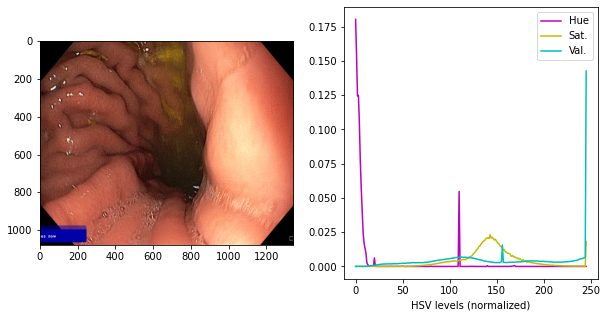

uniformity level = 1.4012657959226801e-05
variance of the laplacian = 1438.3533509876322
entropy of the image = 7.557925991260868


In [40]:
path = rand_pic('grande courbure gastrique',None)

image = cv.imread(path)
print(image.shape)
image = crop(image)
print(image.shape)

display_hist(cv.cvtColor(image, cv.COLOR_BGR2RGB))
uniformity_score = uniformity(image)/(image.shape[0] * image.shape[1])

print("uniformity level = " + str(uniformity_score))
var_lap = var_lap_fct(image)
print("variance of the laplacian = " + str(var_lap))
im_entropy = entropy(image)
print("entropy of the image = " + str(im_entropy)) #VERY SLOW

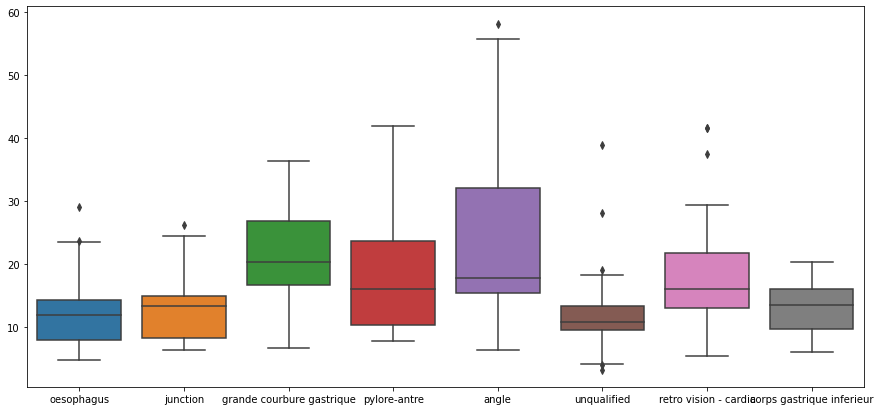

In [41]:
uniformity_df = df_insight(uniformity)
df_to_plot_box(uniformity_df)

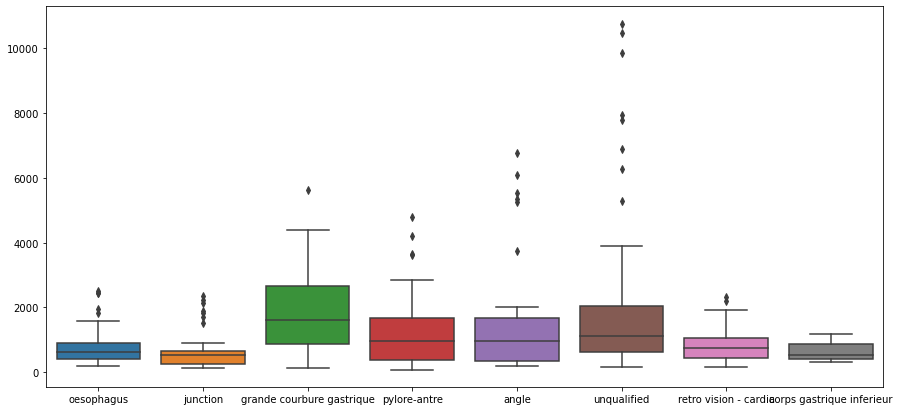

In [42]:
lapvar_df = df_insight(var_lap_fct)
df_to_plot_box(lapvar_df)

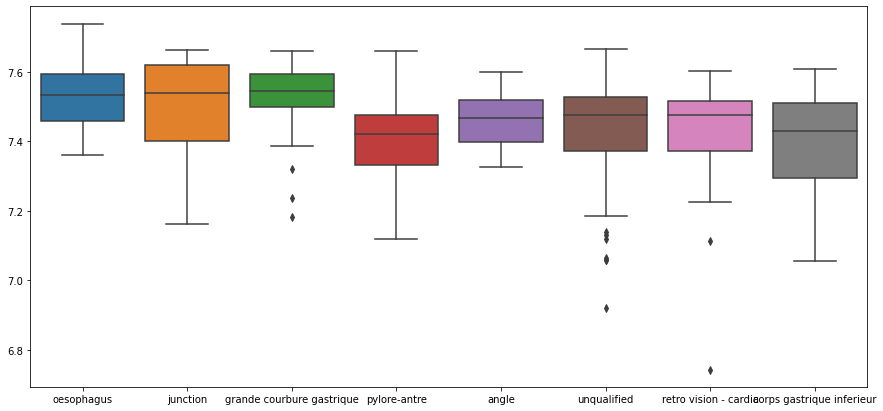

In [43]:
entropy_df = df_insight(entropy)
df_to_plot_box(entropy_df)

In [44]:
mean_hue_df = df_insight(mean_hue)

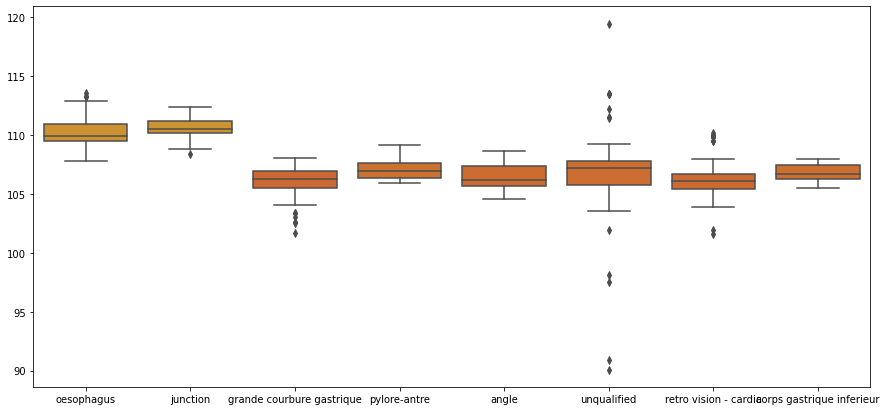

In [45]:
h_means_col =mean_hue_df.mean().unique()

rgb_means_col = [colorsys.hsv_to_rgb(elem/100,0.9,0.9) for elem in h_means_col]

customPalette = sns.set_palette(sns.color_palette(rgb_means_col))
plt.rcParams["figure.figsize"] = [15, 7]
ax = sns.boxplot(data=mean_hue_df,palette=customPalette)
plt.show()